# 東京電力 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '9501.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-24 00:00:00+09:00,778.000000,782.599976,760.099976,760.500000,35177300,0.0,0.0
2024-07-25 00:00:00+09:00,743.799988,750.900024,735.200012,741.000000,31185100,0.0,0.0
2024-07-26 00:00:00+09:00,740.000000,740.099976,718.099976,718.099976,29158300,0.0,0.0
2024-07-29 00:00:00+09:00,723.000000,754.299988,721.400024,746.000000,28873700,0.0,0.0
2024-07-30 00:00:00+09:00,743.700012,757.799988,739.700012,744.900024,21697300,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-20 00:00:00+09:00,424.000000,431.399994,420.500000,428.200012,19949500,0.0,0.0
2025-01-21 00:00:00+09:00,435.500000,437.399994,421.700012,422.700012,18665400,0.0,0.0
2025-01-22 00:00:00+09:00,426.200012,430.299988,420.700012,423.500000,22845000,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

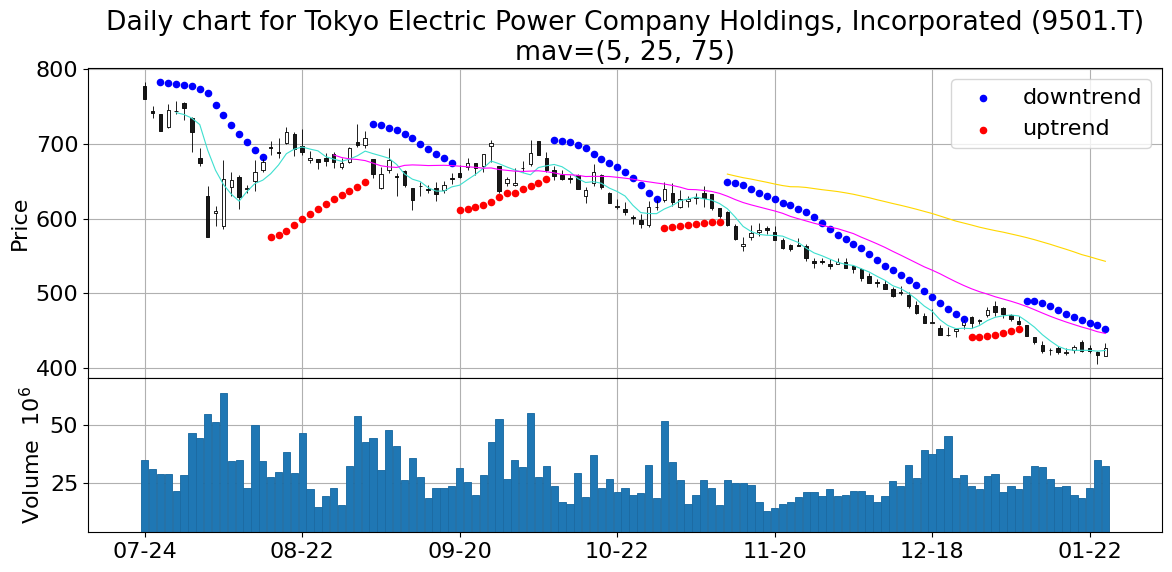

In [4]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [5]:
df.tail(2)['Close']

Date
2025-01-23 00:00:00+09:00    417.000000
2025-01-24 00:00:00+09:00    426.600006
Name: Close, dtype: float64

In [6]:
df.tail(2)['Close'].diff()

Date
2025-01-23 00:00:00+09:00         NaN
2025-01-24 00:00:00+09:00    9.600006
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-23 00:00:00+09:00    422.640002
2025-01-24 00:00:00+09:00    423.600006
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-23 00:00:00+09:00    448.643998
2025-01-24 00:00:00+09:00    446.383998
Name: Close, dtype: float64

In [9]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-01-23 00:00:00+09:00    545.946667
2025-01-24 00:00:00+09:00    542.992001
Name: Close, dtype: float64